In [1]:
!unzip /content/trainPart1.zip

Archive:  /content/trainPart1.zip
   creating: train/
   creating: train/Sample002/
  inflating: train/Sample002/img002-048.png  
  inflating: train/Sample002/img002-050.png  
  inflating: train/Sample002/img002-006.png  
  inflating: train/Sample002/img002-004.png  
  inflating: train/Sample002/img002-053.png  
  inflating: train/Sample002/img002-045.png  
  inflating: train/Sample002/img002-052.png  
  inflating: train/Sample002/img002-047.png  
  inflating: train/Sample002/img002-020.png  
  inflating: train/Sample002/img002-009.png  
  inflating: train/Sample002/img002-011.png  
  inflating: train/Sample002/img002-013.png  
  inflating: train/Sample002/img002-034.png  
  inflating: train/Sample002/img002-038.png  
  inflating: train/Sample002/img002-024.png  
  inflating: train/Sample002/img002-025.png  
  inflating: train/Sample002/img002-018.png  
  inflating: train/Sample002/img002-032.png  
  inflating: train/Sample002/img002-028.png  
  inflating: train/Sample002/img002-001.pn

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir = '/content/train'
classes = os.listdir(data_dir)
print(classes)

['Sample027', 'Sample042', 'Sample050', 'Sample052', 'Sample001', 'Sample003', 'Sample014', 'Sample035', 'Sample025', 'Sample005', 'Sample034', 'Sample033', 'Sample013', 'Sample004', 'Sample054', 'Sample053', 'Sample036', 'Sample049', 'Sample039', 'Sample002', 'Sample026', 'Sample061', 'Sample012', 'Sample031', 'Sample040', 'Sample018', 'Sample060', 'Sample010', 'Sample024', 'Sample019', 'Sample022', 'Sample017', 'Sample038', 'Sample055', 'Sample057', 'Sample016', 'Sample051', 'Sample023', 'Sample020', 'Sample015', 'Sample008', 'Sample048', 'Sample044', 'Sample045', 'Sample030', 'Sample041', 'Sample021', 'Sample028', 'Sample059', 'Sample029', 'Sample032', 'Sample047', 'Sample006', 'Sample009', 'Sample056', 'Sample011', 'Sample037', 'Sample058', 'Sample046', 'Sample043', 'Sample062', 'Sample007']


In [4]:
tfms = tt.Compose([tt.Resize((32,32)),
                         tt.ToTensor()])

In [5]:
dataset = ImageFolder(data_dir,tfms)


In [6]:
val_size = 496
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1984, 496)

In [7]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


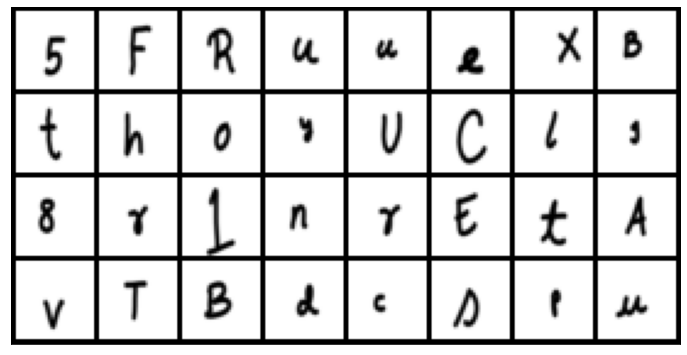

In [9]:
show_batch(train_dl)


In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device


device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [15]:
model = to_device(ResNet9(3, 62), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.015625, 'val_loss': 4.127392768859863}]

In [18]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [19]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00275, train_loss: 4.0061, val_loss: 3.7122, val_acc: 0.1934
Epoch [1], last_lr: 0.00758, train_loss: 3.1421, val_loss: 8.4396, val_acc: 0.1432
Epoch [2], last_lr: 0.01000, train_loss: 2.3040, val_loss: 4.5981, val_acc: 0.2917
Epoch [3], last_lr: 0.00950, train_loss: 1.2437, val_loss: 1.2609, val_acc: 0.6289
Epoch [4], last_lr: 0.00812, train_loss: 0.7187, val_loss: 0.7891, val_acc: 0.7669
Epoch [5], last_lr: 0.00611, train_loss: 0.4723, val_loss: 0.8321, val_acc: 0.7637
Epoch [6], last_lr: 0.00389, train_loss: 0.3399, val_loss: 0.5545, val_acc: 0.8249
Epoch [7], last_lr: 0.00188, train_loss: 0.1736, val_loss: 0.4621, val_acc: 0.8411
Epoch [8], last_lr: 0.00050, train_loss: 0.1027, val_loss: 0.4388, val_acc: 0.8490
Epoch [9], last_lr: 0.00000, train_loss: 0.0767, val_loss: 0.4364, val_acc: 0.8529
CPU times: user 16.2 s, sys: 2.94 s, total: 19.1 s
Wall time: 5min 37s


In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00275, train_loss: 0.2107, val_loss: 0.8645, val_acc: 0.7559
Epoch [1], last_lr: 0.00758, train_loss: 0.8660, val_loss: 4.5635, val_acc: 0.2357
Epoch [2], last_lr: 0.01000, train_loss: 0.9148, val_loss: 1.5269, val_acc: 0.6296
Epoch [3], last_lr: 0.00950, train_loss: 0.6659, val_loss: 1.4057, val_acc: 0.6270
Epoch [4], last_lr: 0.00812, train_loss: 0.4465, val_loss: 0.7813, val_acc: 0.7930
Epoch [5], last_lr: 0.00611, train_loss: 0.2911, val_loss: 0.8306, val_acc: 0.7839
Epoch [6], last_lr: 0.00389, train_loss: 0.1828, val_loss: 0.7403, val_acc: 0.8210
Epoch [7], last_lr: 0.00188, train_loss: 0.0986, val_loss: 0.5267, val_acc: 0.8470
Epoch [8], last_lr: 0.00050, train_loss: 0.0465, val_loss: 0.5413, val_acc: 0.8451
Epoch [9], last_lr: 0.00000, train_loss: 0.0354, val_loss: 0.5344, val_acc: 0.8464
CPU times: user 16.3 s, sys: 3.51 s, total: 19.8 s
Wall time: 5min 31s


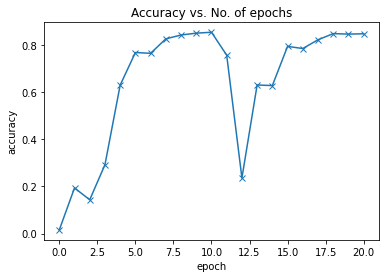

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

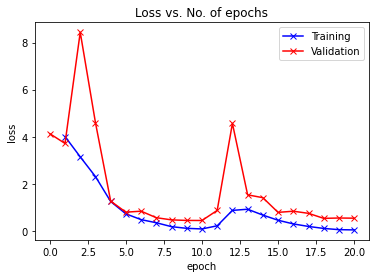

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

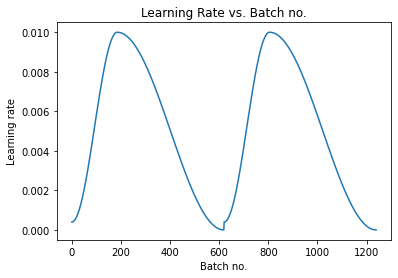

In [23]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [24]:
torch.save(model, '/content/WEIGHTS/Midas_A')

